In [1]:
import numpy as np
from myplotstyle import plt, get_figsize, legend_ordered

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H
from SAGA.database import GoogleSheets

from astropy.table import Table
import io
import pandas as pd

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
base = Query(C.sat_rcut, "p_sat_corrected > 0").filter(base)
sats = C.is_sat.filter(base)

In [5]:
def write_latex_table(t, formats=None, write_to=None, display=True, edit_func=None):
    if formats is None:
        formats = {}
    if not isinstance(formats, dict):
        formats = {c: f for c, f in zip(t.colnames, formats, strict=True)}

    fp = io.StringIO()
    t.write(fp, format="ascii.latex", formats=formats)
    lines = fp.getvalue().splitlines()
    if edit_func is not None:
        lines = edit_func(lines)
    lines[-3] = lines[-3].rstrip("\\")

    fp = io.StringIO()
    fp.write("\n".join(lines[3:-2]))
    fp.write("\n")
    out = fp.getvalue()

    if write_to:
        with open(write_to, "w") as fp:
            fp.write(out)

    if display:
        print(out)

In [6]:
# compiled/coded by Yasmeen with https://github.com/yasmeenasali/compile_elves/blob/main/elves_data_compilation.ipynb
elves_df = pd.read_csv('data/compiled_elves_data.csv')

# LOAD GRAND LIST
grand_list = saga.host_catalog.load_master_list()

# MAKE LIST OF 28 ELVES HOST NAMES
elves_host_list = elves_df.Name_Host.value_counts().keys()

# ACCOUNTING FOR ELVES HOSTS THAT HAVE DIFF NAMES IN GRAND LIST
elves_name_dict = {'CENA'  :'NGC5128',
                   'M104'  :'NGC4594',
                   'M81'  :'NGC3031',
                   'NGC253'  :'NGC0253',
                   'NGC4517'  :'NGC4437',
                   'NGC628'  :'NGC0628',
                   'NGC891'  :'NGC0891'}
rev_elves_name_dict = { v:k for k,v in elves_name_dict.items()}
# REMAKE LIST OF ELVES HOSTS, NOW SWAPPING IN GRAND LIST NAMES
elves_host_list_grand_list_convention = [elves_name_dict.get(item,item)  for item in elves_host_list]

# DEFINE MINIMAL SAGA HOST CUTS (ENV + STELLAR MASS CUTS)
min_cuts = Query(
    "BRIGHTEST_K_R1 >= K_TC + 1.6",
    "M_HALO < 13",
    "K_ABS >= -24.6",
    "K_ABS <= -23.0"
)

# APPLY CUTS TO GRAND LIST
min_cuts_df = min_cuts.filter(grand_list).to_pandas()

# CROSSMATCH ELVES SELECTED GRAND LIST WITH ELVES DF USING ELVES NAMES
elves_min_cuts_list_glc = min_cuts_df[min_cuts_df['COMMON_NAME'].isin(elves_host_list_grand_list_convention)]['COMMON_NAME'].values
elves_min_cuts_list = [rev_elves_name_dict.get(item,item)  for item in elves_min_cuts_list_glc]
elves_min_cuts_df = elves_df[elves_df['HOST'].isin(elves_min_cuts_list)].copy()
print(len(elves_min_cuts_list))
print(" ".join(elves_min_cuts_list))
print("NGC", ", ".join(elves_min_cuts_list).replace("NGC", ""))

14
NGC253 NGC628 NGC891 NGC1023 NGC1291 NGC2683 NGC2903 NGC3115 NGC4258 NGC4736 NGC5055 NGC5236 NGC5457 NGC6744
NGC 253, 628, 891, 1023, 1291, 2683, 2903, 3115, 4258, 4736, 5055, 5236, 5457, 6744


10.31 & 0.026 & 0.026 & 0.000 & 0.000 & 0.026 & 0.026 \\
\phn9.94 & 0.185 & 0.185 & 0.106 & 0.106 & 0.079 & 0.079 \\
\phn9.56 & 0.475 & 0.475 & 0.449 & 0.449 & 0.026 & 0.026 \\
\phn9.19 & 0.475 & 0.475 & 0.449 & 0.449 & 0.027 & 0.026 \\
\phn8.81 & 0.820 & 0.818 & 0.713 & 0.713 & 0.107 & 0.106 \\
\phn8.44 & 1.041 & 1.030 & 0.818 & 0.818 & 0.222 & 0.211 \\
\phn8.06 & 1.524 & 1.452 & 1.135 & 1.135 & 0.389 & 0.317 \\
\phn7.69 & 2.304 & 1.954 & 1.417 & 1.399 & 0.887 & 0.554 \\
\phn7.31 & 3.111 & 1.927 & 1.312 & 1.241 & 1.798 & 0.686 \\
\phn6.94 & 5.950 & 1.162 & 1.218 & 0.950 & 4.732 & 0.211 \\
\phn6.56 & 4.376 & 0.317 & 1.306 & 0.238 & 3.071 & 0.079 



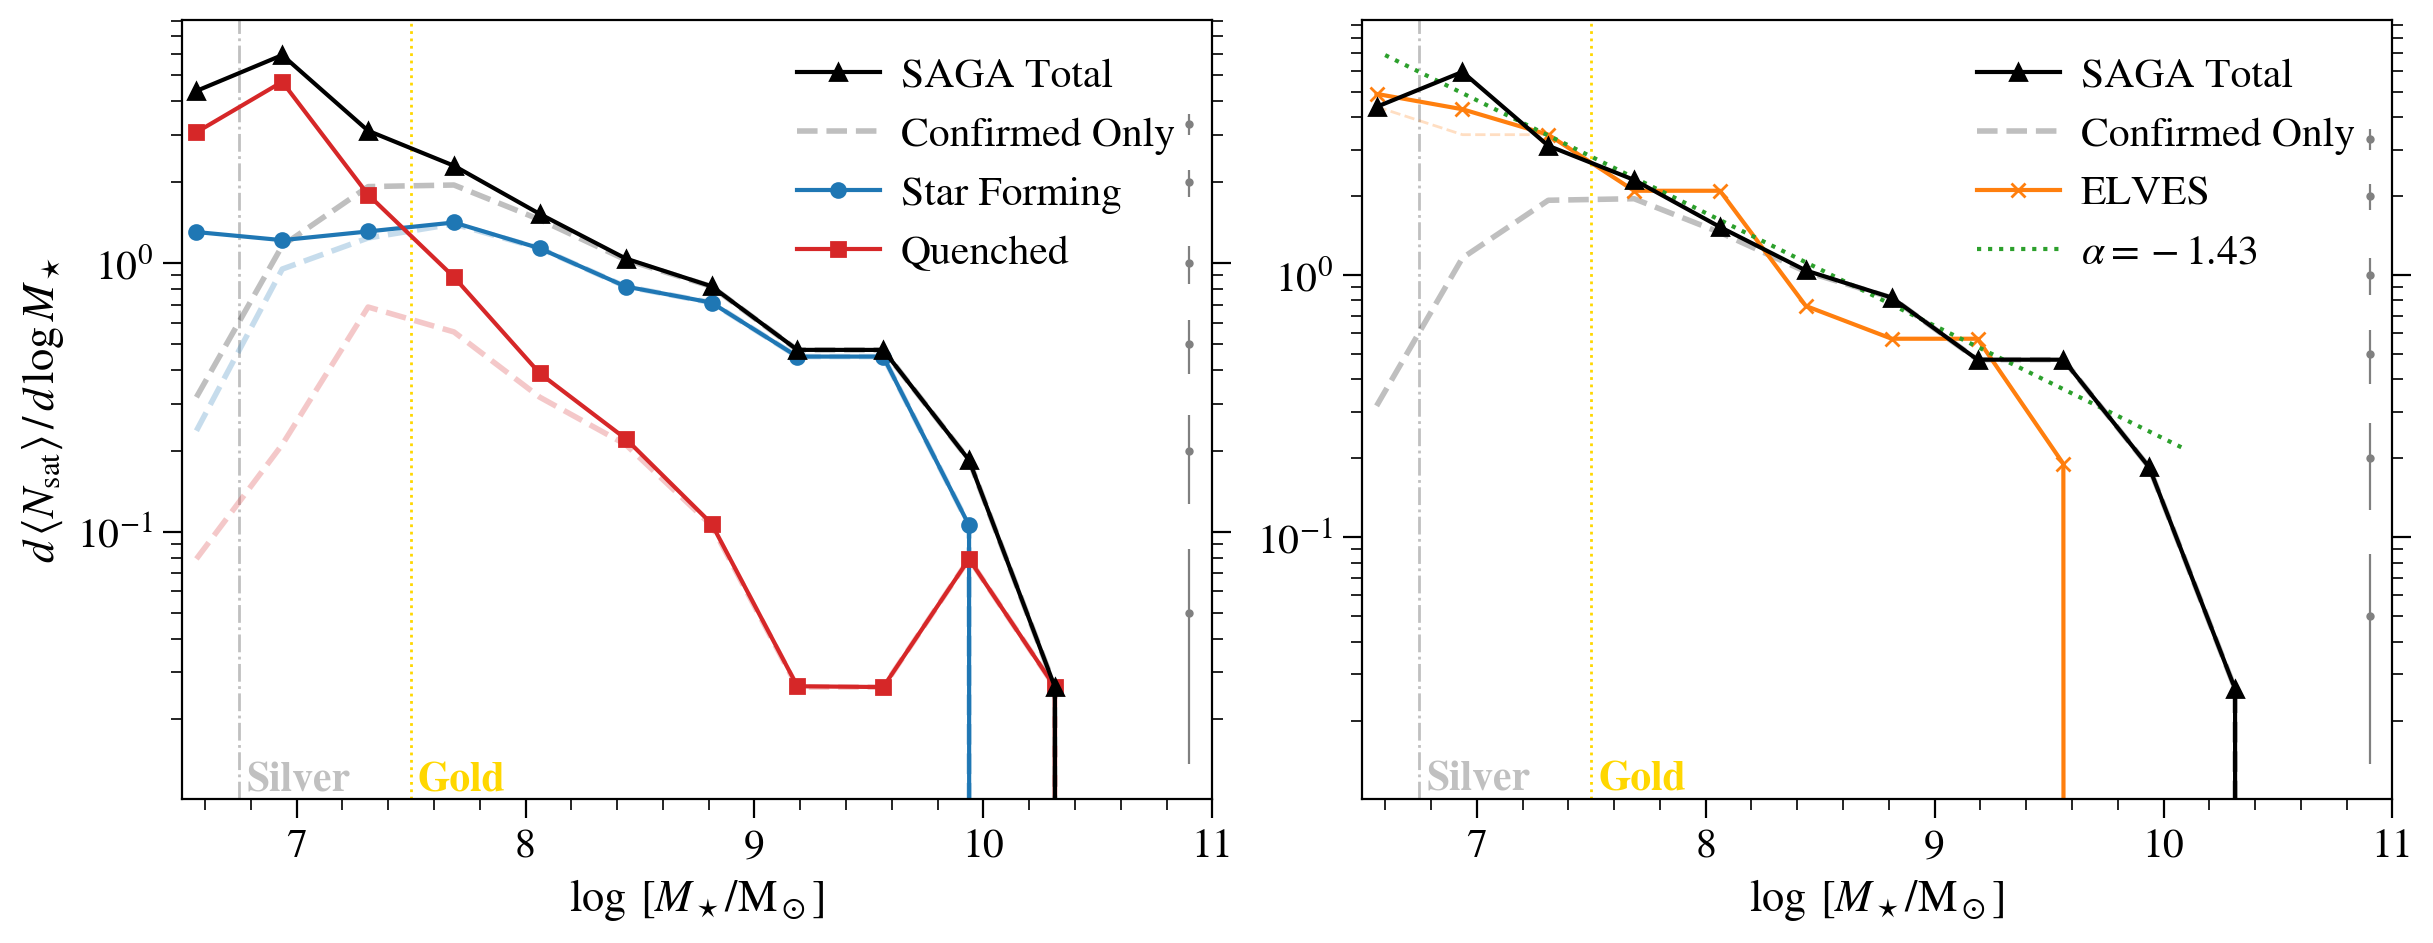

In [7]:
bins = np.linspace(6.375, 10.875, 13)
x = 0.5 * (bins[1:] + bins[:-1])

fig, ax = plt.subplots(ncols=2, figsize=get_figsize(wide=True, ratio=2.7))

y = np.histogram(sats["log_sm"], bins=bins)[0] / np.ediff1d(bins) / nhosts
v = Query(~C.is_sat).filter(base)
y1 = np.histogram(v["log_sm_phony"], bins=bins, weights=v["p_sat_corrected"])[0] / np.ediff1d(bins) / nhosts
for ax_this in ax:
    ax_this.plot(x, y, '--', c="k", alpha=0.25,  label="Confirmed Only", lw=2)
    ax_this.plot(x,y+y1,'^-', color="k", label="SAGA Total", zorder=90, lw=1.5, ms=6)
to_print = [x, y+y1, y]

ax_this = ax[0]
v = Query("quenched == 0").filter(sats)
y = np.histogram(v["log_sm"], bins=bins)[0] / np.ediff1d(bins) / nhosts
v = Query(~C.color_quenched_def, ~C.is_sat).filter(base)
y1 = np.histogram(v["log_sm_phony"], bins=bins, weights=v["p_sat_corrected"])[0] / np.ediff1d(bins) / nhosts
ax_this.plot(x, y, '--', c="C0", alpha=0.25, lw=2)
ax_this.plot(x,y+y1,'o-', color="C0", label="Star Forming", lw=1.5, ms=5)
to_print.extend([y+y1, y])

v = Query("quenched == 1").filter(sats)
y = np.histogram(v["log_sm"], bins=bins)[0] / np.ediff1d(bins) / nhosts
v = Query(C.color_quenched_def, ~C.is_sat).filter(base)
y1 = np.histogram(v["log_sm_phony"], bins=bins, weights=v["p_sat_corrected"])[0] / np.ediff1d(bins) / nhosts
ax_this.plot(x, y, '--', c="C3", alpha=0.25, lw=2)
ax_this.plot(x,y+y1,'s-', color="C3", label="Quenched", lw=1.5)
to_print.extend([y+y1, y])

ax_this = ax[1]

# new code for elves starts here (by Yasmeen)
nhost_min_cuts = len(elves_min_cuts_df.groupby('HOST').groups.keys())
y = np.histogram(elves_min_cuts_df["log_sm"], bins=bins, weights=elves_min_cuts_df["Psat"])[0] / np.ediff1d(bins) / nhost_min_cuts
yc = np.histogram(elves_min_cuts_df["log_sm"], bins=bins, weights=elves_min_cuts_df["Confirmed"].astype(int))[0] / np.ediff1d(bins) / nhost_min_cuts
plt.plot(x, y, 'x-', c="C1", label=f"ELVES", lw=1.5)
plt.plot(x, yc, '--', c="C1", lw=1, alpha=0.25)

x = np.linspace(6.6, 10.1, 3)
ax_this.plot(x, (10**(x-8.55))**(-0.43), color="C2", ls=":", label=r"$\alpha = -1.43$")

legend_ordered(ax[0], [1,0,2,3], loc="upper right")
legend_ordered(ax[1], [1,0,2,3], loc="upper right")

for ax_this in ax:
    # typical errorbar
    y = np.array([0.05, 0.2, 0.5, 1, 2, 3.3])
    ax_this.errorbar([10.9]*len(y), y, yerr=np.sqrt(y / np.ediff1d(bins).mean() / nhosts), marker=".", c="grey", ls="", lw=0.8, ms=4)
    ax_this.set_yscale("log")
    ax_this.set_xlabel(r"$\log\;[M_\star/{\rm M}_\odot]$")
    ax_this.axvline(7.5, lw=1, ls=":", color="gold", zorder=-1)
    ax_this.axvline(6.75, lw=1, ls="-.",color="silver", zorder=-1)
    ax_this.set_xlim(6.5, 11)
    ax_this.yaxis.set_ticks_position('both')
    ax_this.text(7.53, 0.01, "Gold", color="gold", fontweight="bold", va="bottom")
    ax_this.text(6.78, 0.01, "Silver", color="silver", fontweight="bold", va="bottom")

ax[0].set_ylabel(r"$d \, \langle N_{\rm sat} \rangle \, / \, d \, \log M_\star$")

plt.savefig("plots/sat_smf.pdf")

def edit_func(lines):
    lines[3] = lines[3][4:]
    return lines

write_latex_table(
    Table(np.vstack(to_print).T)[-2::-1],
    formats=(["\\phn%.2f"] + ["%.3f"]*6),
    write_to="tables/data_smf.tex",
    edit_func=edit_func,
)

## Rainbow plot

In [8]:
color_dict = np.load("data/color_dict.npz")  # generated by F06-satellite mosaic.ipynb

In [9]:
lg_sats = GoogleSheets("1TDbjRUVtKjvLR7pC-OaFt9xH4kZ6B_Am65tLyuDx4T0", gid=0).read()  # compiled by Mia
lg_sats = lg_sats[lg_sats["Mstar (1e6 Msun)"] > 0]
lg_sats["log_sm"] = np.log10(lg_sats["Mstar (1e6 Msun)"]) + 6
mw_sats, m31_sats = QueryMaker.contains_str("Association", "MW").split(lg_sats, ["Name", "log_sm"])

In [10]:
smf_data = dict()
log_sm_min = 6
log_sm_max = 11


def get_cdf_for_plot(x, x_start, x_end, weight=None, weight_confirmed=None):
    _x = np.concatenate([[x_start], np.repeat(np.array(x), 2), [x_end]])
    if weight is None:
        weight = np.ones(len(x))
    _y = np.repeat(np.insert(np.cumsum(weight), 0, 0), 2)
    _yc = _y if weight_confirmed is None else np.repeat(np.insert(np.cumsum(weight_confirmed), 0, 0), 2)
    return dict(x=_x, y=_y, yc=_yc)


for base_this in base.group_by("HOSTID").groups:
    host_this = base_this["HOSTID"][0]
    base_this = Query(QueryMaker.equal("HOSTID", host_this), f"log_sm_phony >= {log_sm_min}", f"log_sm_phony < {log_sm_max}").filter(base, ["log_sm_phony", "p_sat_corrected", "SATS"])
    base_this.sort('log_sm_phony', reverse=True)
    smf_data[host_this] = get_cdf_for_plot(base_this['log_sm_phony'], log_sm_max, log_sm_min, base_this['p_sat_corrected'], C.is_sat.mask(base_this).astype(np.int64))


smf_data["MW"] = get_cdf_for_plot(mw_sats['log_sm'], log_sm_max, log_sm_min)
smf_data["M31"] = get_cdf_for_plot(m31_sats['log_sm'], log_sm_max, log_sm_min)

In [11]:
hosts = saga.host_catalog.load(query="paper3", include_stats=True)

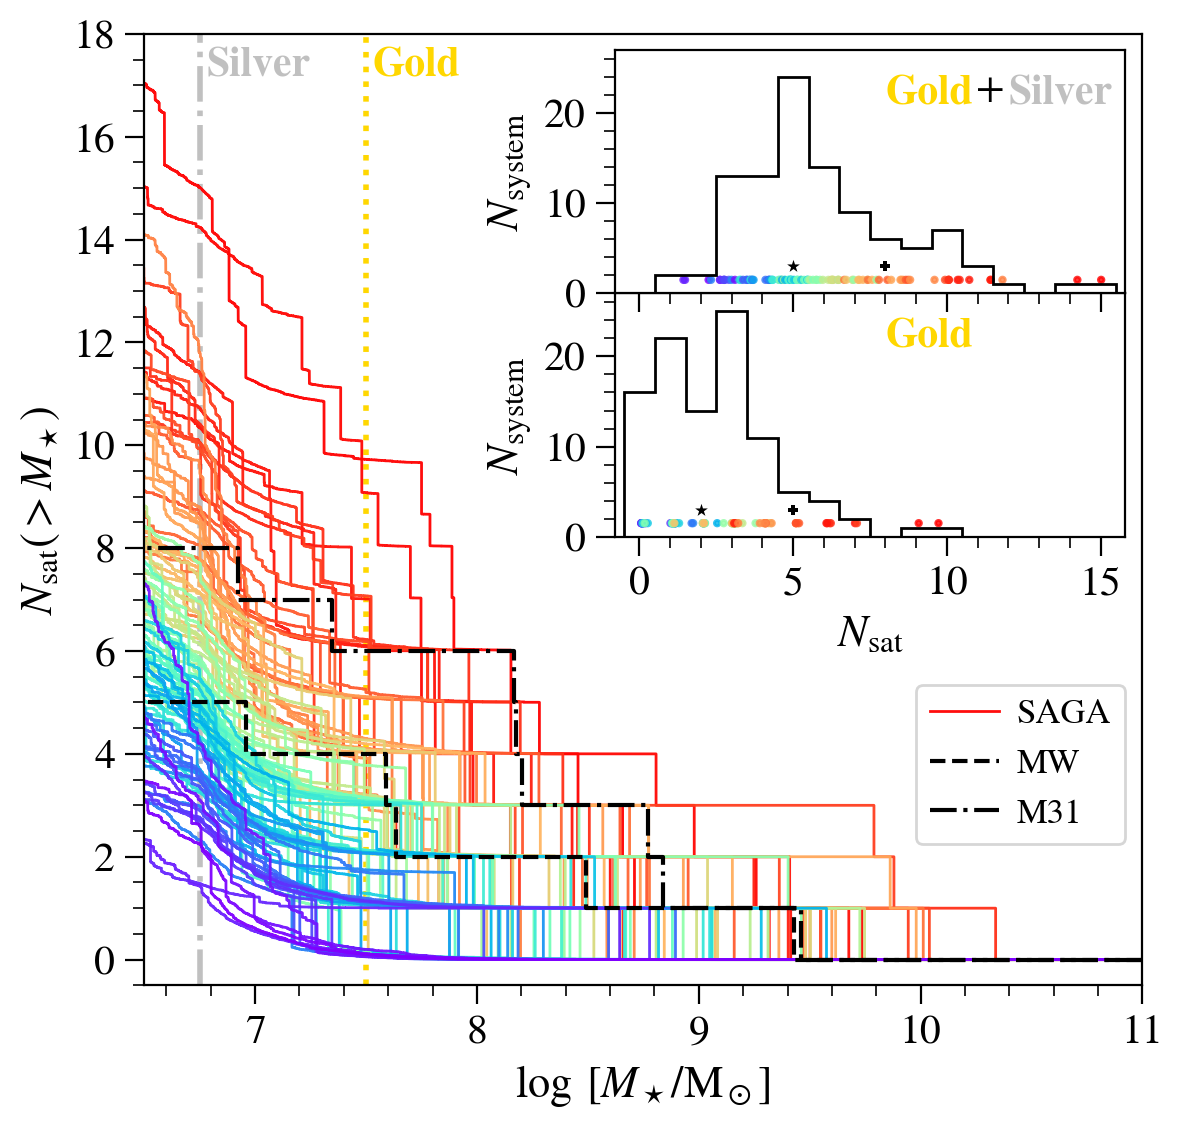

In [12]:
fig, ax = plt.subplots(figsize=get_figsize(ratio=1.05))

for i, (hostid, color) in enumerate(color_dict.items()):
    ax.plot(smf_data[hostid]["x"], smf_data[hostid]["y"], c=color, lw=1, alpha=0.95, label=(None if i else "SAGA"))

for hostid, ls in zip(("MW", "M31"), ('--', '-.'), strict=True):
    ax.plot(smf_data[hostid]["x"], smf_data[hostid]["y"], lw=1.5, c="k", label=hostid, ls=ls)

ax.set_xlim(6.5, 11)
ax.set_ylim(-0.5, 18)
ax.set_yticks(np.arange(0, 19, 2))
ax.set_xlabel(r"$\log\;[M_\star/{\rm M}_\odot]$")
ax.set_ylabel(r"$N_{\rm sat}(> M_\star)$")
ax.legend(loc="lower right", bbox_to_anchor=(1, 0.13), handlelength=2, frameon=True, fontsize="small")

ax_inset1 = fig.add_axes([0.52, 0.525, 0.44, 0.22])
ax_inset2 = fig.add_axes([0.52, 0.745, 0.44, 0.22])

ax_inset1.hist(hosts["sats_gold"], np.linspace(-0.5, 15.5, 17), histtype="step", color="k", lw=1)
ax_inset2.set_xticklabels([])
ax_inset2.hist(hosts["sats_gold_silver"], np.linspace(-0.5, 15.5, 17), histtype="step", color="k", lw=1)

hosts.sort("sats_gold_silver")
ax_inset1.scatter(hosts["sats_gold"], np.ones(len(hosts))*1.5, c=[color_dict[h] for h in hosts["HOSTID"]], s=4, alpha=0.8)
ax_inset2.scatter(hosts["sats_gold_silver"], np.ones(len(hosts))*1.5, c=[color_dict[h] for h in hosts["HOSTID"]], s=4, alpha=0.8)
ax_inset1.set_xlabel(r"$N_{\rm sat}$")

# MW
ax_inset1.scatter([2], [3], c="k", marker="*", s=23, lw=0)
ax_inset2.scatter([5], [3], c="k", marker="*", s=23, lw=0)

# M31
ax_inset1.scatter([5], [3], c="k", marker="P", s=11, lw=0)
ax_inset2.scatter([8], [3], c="k", marker="P", s=11, lw=0)

for ax_this in [ax_inset1, ax_inset2]:
    ax_this.set_xlim(-0.8, 15.8)
    ax_this.set_ylim(0, 27)
    ax_this.set_ylabel(r"$N_{\rm system}$")
    ax_this.set_yticks([0, 10, 20])

ax.axvline(7.5, lw=2, ls=":", color="gold", zorder=-1)
ax.axvline(6.75, lw=2, ls="-.",color="silver", zorder=-1)
ax.text(7.53, 17, "Gold", color="gold", fontweight="bold", va="bottom")
ax.text(6.78, 17, "Silver", color="silver", fontweight="bold", va="bottom")

ax_inset1.text(8, 21, "Gold", color="gold", fontweight="bold")
ax_inset2.text(8, 21, "Gold", color="gold", fontweight="bold")
ax_inset2.text(10.9, 21.5, "$+$")
ax_inset2.text(12, 21, "Silver", color="silver", fontweight="bold",)

plt.savefig("plots/sat_smf_rainbow.pdf")